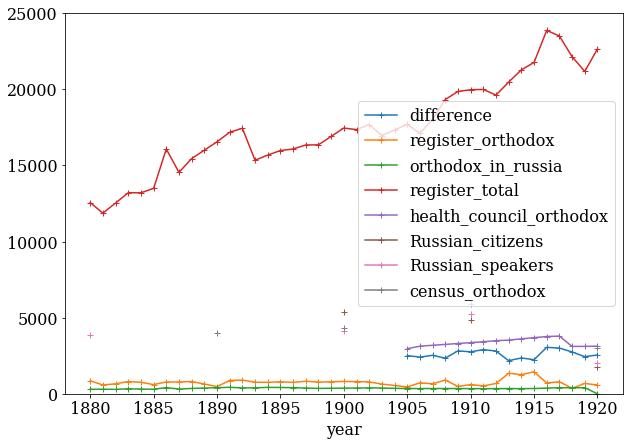

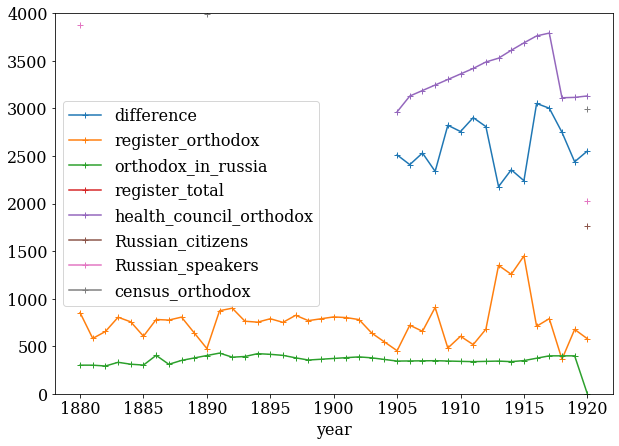

In [33]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('../data')
figure_dir = Path('../figures')
figure_dir.mkdir(exist_ok=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
remove = poll_tax.in_russia_orthodox.copy()
remove.loc['1906':] = 0
poll_tax['orthodox'] = poll_tax.orthodox - remove
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
data = pd.DataFrame([
    difference,
    poll_tax.orthodox,
    poll_tax.in_russia_orthodox,
    poll_tax.total,
    health_council,
    foreigners,
    language,
    religion,
]).T
data.columns = [
    'difference',
    'register_orthodox',
    'orthodox_in_russia',
    'register_total',
    'health_council_orthodox',
    'Russian_citizens',
    'Russian_speakers',
    'census_orthodox',
]
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 25_000))
plt.savefig(figure_dir / 'timeseries1.png')
data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 4_000))
plt.savefig(figure_dir / 'timeseries2.png')

## Fourier analysis

No few-year clear cycle detectable

[20.5        13.66666667 10.25        8.2         6.83333333  5.85714286
  5.125       4.55555556  4.1         3.72727273  3.41666667  3.15384615
  2.92857143  2.73333333  2.5625      2.41176471  2.27777778  2.15789474
  2.05      ]


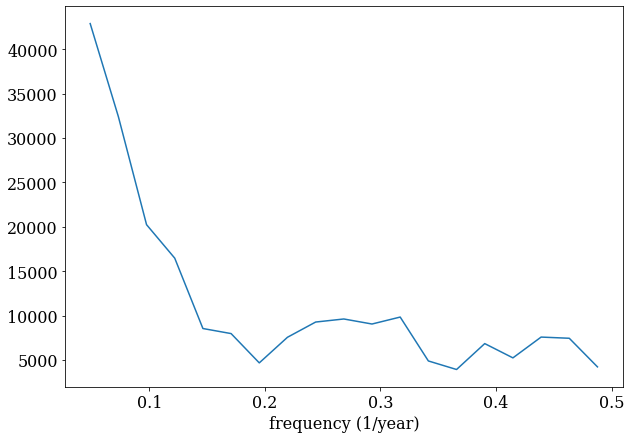

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

ft = np.abs(rfft(data['register_total']))[2:]
freq = rfftfreq(len(data.index))[2:]

plt.figure(figsize=(10, 7))
plt.plot(freq, ft)

plt.xlabel('frequency (1/year)')
# plt.show()
plt.savefig(figure_dir / 'fourier.png')

print(1/freq)

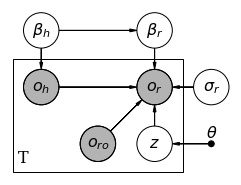

In [35]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('health_orthodox', r'$o_{h}$', 1, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_orthodox', r'$o_{r}$', 3, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('russia_orthodox', r'$o_{ro}$', 2, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('beta_orthodox_health', r'$\beta_h$', 1, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_register', r'$\beta_r$', 3, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('theta', r'$\theta$', 4, 1, fixed=True, scale=scale, observed=False)
pgm.add_node('z', r'$z$', 3, 1, fixed=False, scale=scale, observed=False)
pgm.add_node('sigma_register', r'$\sigma_r$', 4, 2, fixed=False, scale=scale, observed=False)

pgm.add_edge('health_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('russia_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('z', 'register_orthodox', directed=True)
pgm.add_edge('beta_orthodox_health', 'health_orthodox', directed=True)
pgm.add_edge('beta_orthodox_health', 'beta_orthodox_register', directed=True)
pgm.add_edge('beta_orthodox_register', 'register_orthodox', directed=True)
pgm.add_edge('sigma_register', 'register_orthodox', directed=True)
pgm.add_edge('theta', 'z', directed=True)

pgm.add_plate([0.5, 0.5, 3, 2], 'T')

pgm.render()

Model:

$ o_r = N(\mu_{o_h}, \sigma_{o_h}^2) $

$ \mu_{o_h} = \beta_0 + \beta_1 t - o_{ro} z $

$ \sigma_{o_h} \sim Exp(10) $

$ \theta = \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix}' $

$ z \sim Bernoulli(\theta) $

$ \beta_h \sim N\begin{pmatrix}\begin{bmatrix} 0.2 \\ 0.005 \end{bmatrix},
 \begin{bmatrix} 0.01 && 0 \\ 0 && 0.001 \end{bmatrix}\end{pmatrix} $

$ \beta_r \sim N\begin{pmatrix}\begin{bmatrix} 0.21 \times 0.3 \\ 0.004 \end{bmatrix},
 \begin{bmatrix} 0.005 && 0 \\ 0 && 0.001 \end{bmatrix}\end{pmatrix} $

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 23200
Interrupted at 23,199 [11%]: Average Loss = 1.9447e+06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_total, beta_early_1, beta_early_0]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8832765165899602, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_total, beta_early_1, beta_early_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

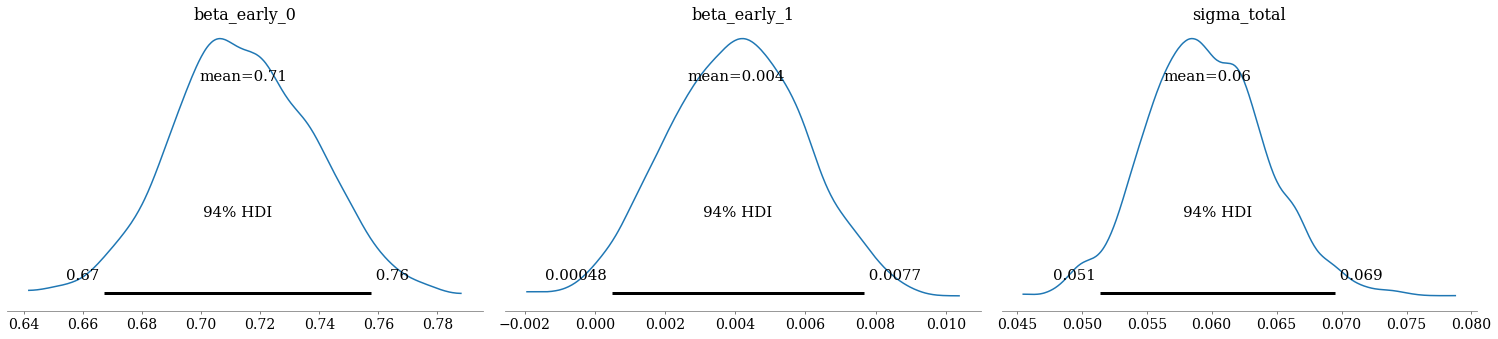

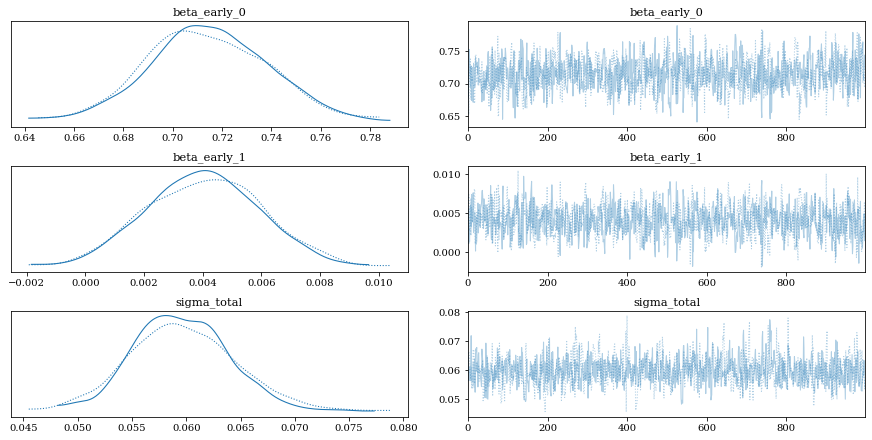

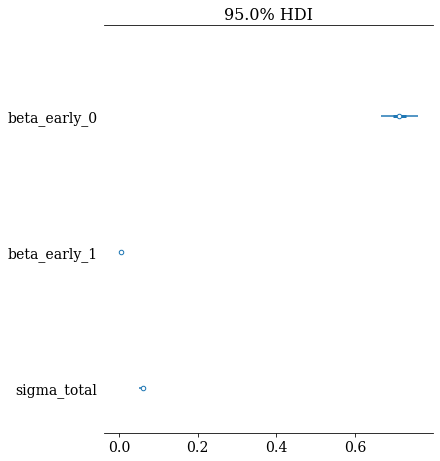

In [36]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

data_pm = data.iloc[:26,].drop([1889, 1899, 1903, 1904, 1905])
standard = 1_000
data_pm = data_pm / standard
start = 1880
data_pm['t'] = data_pm.index - start

with pm.Model() as model_early_orthodox:
    t = np.asarray(data_pm.t)
    beta_early_0 = pm.Normal(
        "beta_early_0",
        mu=0.7,
        sigma=0.1,
    )
    beta_early_1 = pm.Normal(
        "beta_early_1",
        mu=0,
        sigma=0.01,
    )
    sigma_total = pm.HalfNormal(
        'sigma_total',
        sigma=0.01,
    )
    mu_early = beta_early_0 + beta_early_1 * t
    early = pm.Normal(
        'early',
        mu=mu_early,
        sigma=sigma_total,
        observed=data_pm.register_orthodox,
    )
    trace_early = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior_early = pm.sample_prior_predictive()
    posterior_early = pm.sample()
    posterior_pred_early = pm.sample_posterior_predictive(posterior_early)

az.plot_posterior(posterior_early)
az.plot_trace(posterior_early)
az.plot_forest(posterior_early, combined=True, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 15600
Interrupted at 15,599 [7%]: Average Loss = 4.2849e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_total, beta_health_1, beta_health_0]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_total, beta_health_1, beta_health_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

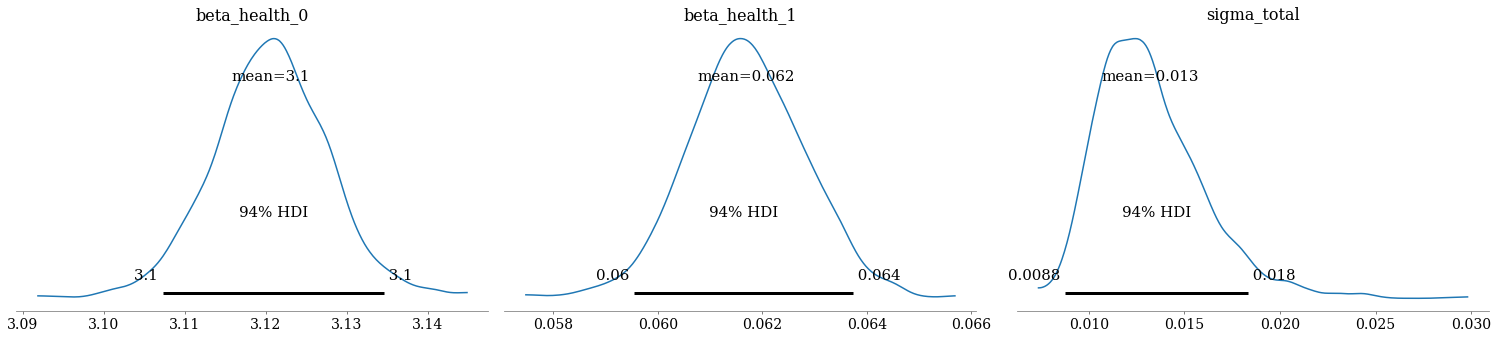

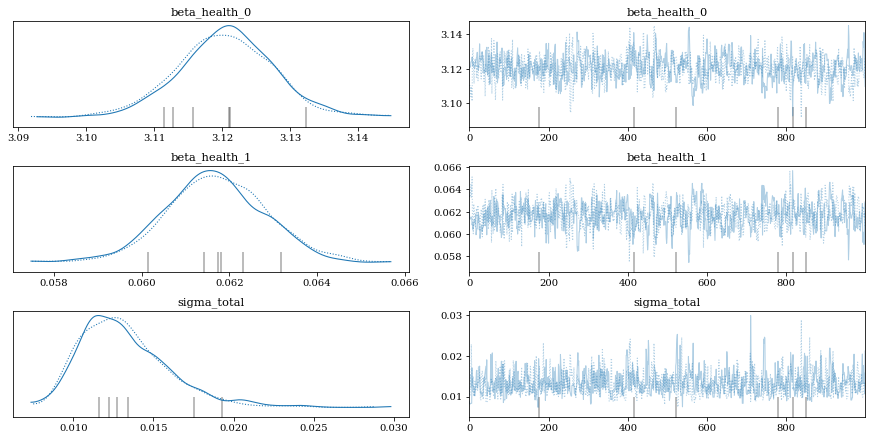

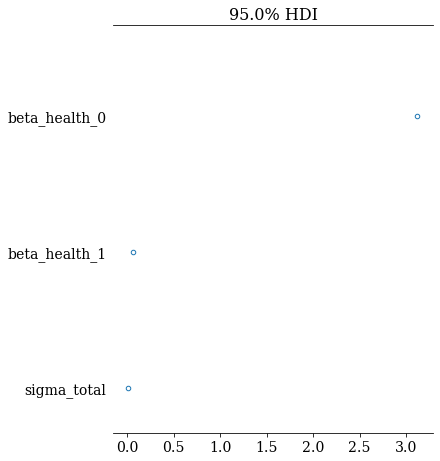

In [37]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

data_pm = data.iloc[26:-3,]
standard = 1_000
data_pm = data_pm / standard
start = 1906
data_pm['t'] = data_pm.index - start

with pm.Model() as model_health_council_orthodox:
    t = np.asarray(data_pm.t)
    beta_health_0 = pm.Normal(
        "beta_health_0",
        mu=3,
        sigma=0.1,
    )
    beta_health_1 = pm.Normal(
        "beta_health_1",
        mu=0.05,
        sigma=0.01,
    )
    sigma_total = pm.HalfNormal(
        'sigma_total',
        sigma=0.01,
    )
    mu_health = beta_health_0 + t * beta_health_1
    health_council = pm.Normal(
        'health_council',
        mu=mu_health,
        sigma=sigma_total,
        observed=data_pm.health_council_orthodox,
    )
    trace_health = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior_health = pm.sample_prior_predictive()
    posterior_health = pm.sample()
    posterior_pred_health = pm.sample_posterior_predictive(posterior_health)

az.plot_posterior(posterior_health)
az.plot_trace(posterior_health)
az.plot_forest(posterior_health, combined=True, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 15700
Interrupted at 15,699 [7%]: Average Loss = 1.8856e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_total, beta_orthodox_1, beta_orthodox_0]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_total, beta_orthodox_1, beta_orthodox_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

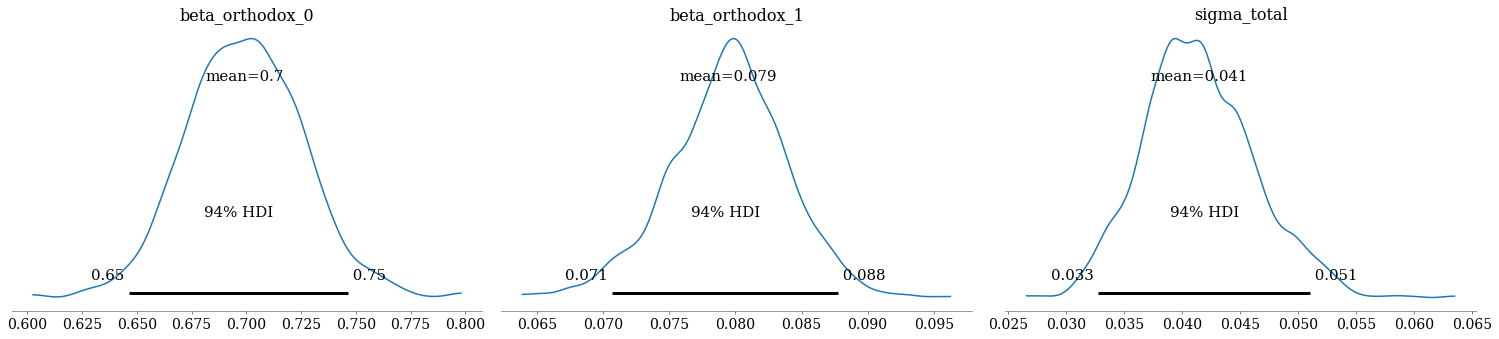

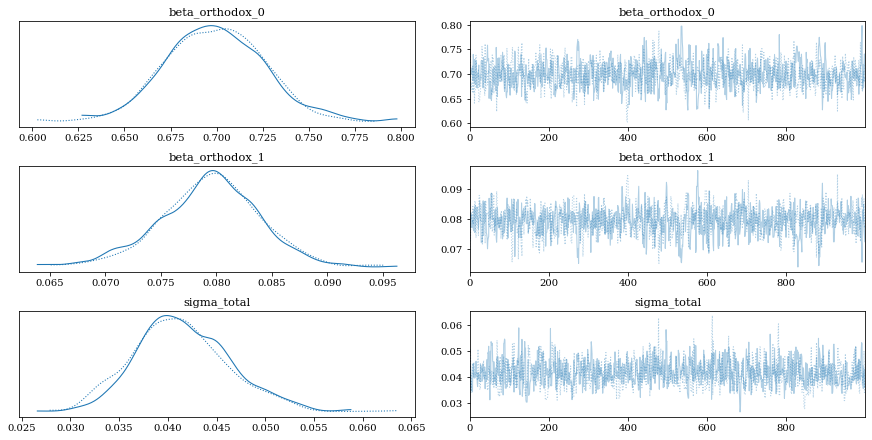

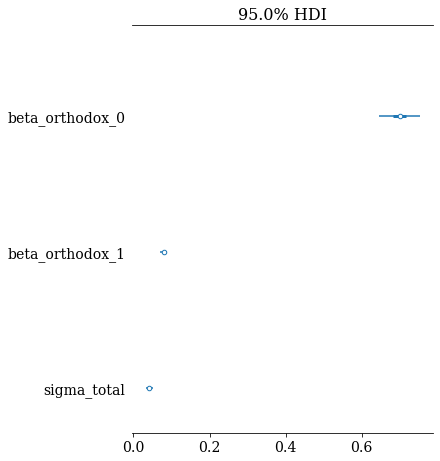

In [38]:
data_pm = data_pm.iloc[[0, 1, 2, 7, 8, 9,]]

mu_beta_orthodox_0 = 3.1 * 0.3
mu_beta_orthodox_1 = 0.062
sigma_total = 0.01

with pm.Model() as model_orthodox:
    t = np.asarray(data_pm.t)
    beta_orthodox_0 = pm.Normal(
        "beta_orthodox_0",
        mu=mu_beta_orthodox_0,
        sigma=1,
    )
    beta_orthodox_1 = pm.Normal(
        "beta_orthodox_1",
        mu=mu_beta_orthodox_1,
        sigma=0.01,
    )
    sigma_total = pm.HalfNormal(
        'sigma_total',
        sigma=0.01,
    )
    mu_total = beta_orthodox_0 + beta_orthodox_1 * t
    total = pm.Normal(
        'register',
        mu=mu_total,
        sigma=sigma_total,
        observed=data_pm.register_orthodox,
    )
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.95)

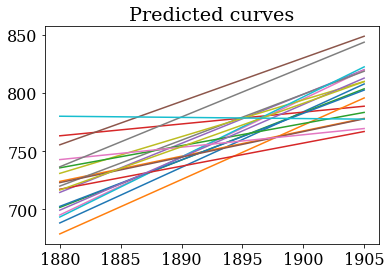

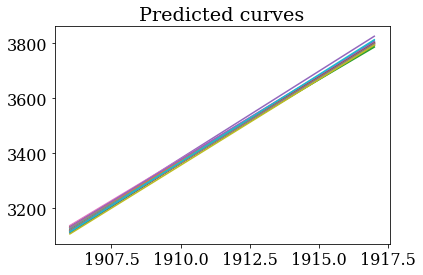

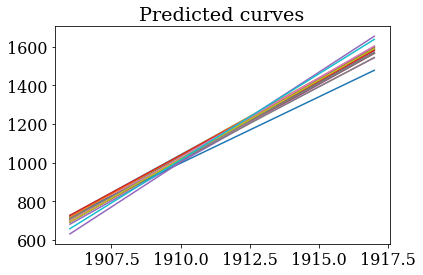

In [39]:
def plot_prediction(
        data,
        intercept_col,
        slope_col,
        standard,
        skip=100,
        start=1906,
        end=1918,
):
    year = np.arange(start, end, 1)
    intercept = data[intercept_col][::skip, ] * standard
    t = data[slope_col][::skip, ] * standard

    for sample in zip(intercept, t):
        total = sample[0] + sample[1] * (year - start)
        plt.plot(year, total)
    plt.title(f'Predicted curves')
    plt.show()

plot_prediction(
    posterior_early,
    intercept_col='beta_early_0',
    slope_col='beta_early_1',
    standard=standard,
    start=1880,
    end=start,
)

plot_prediction(
    posterior_health,
    intercept_col='beta_health_0',
    slope_col='beta_health_1',
    standard=standard,
    start=start,
)

plot_prediction(
    posterior,
    intercept_col='beta_orthodox_0',
    slope_col='beta_orthodox_1',
    standard=standard,
    start=start,
)

year
1906    0.721
1907    0.657
1908    0.908
1913    1.350
1914    1.256
1915    1.449
Name: register_orthodox, dtype: float64


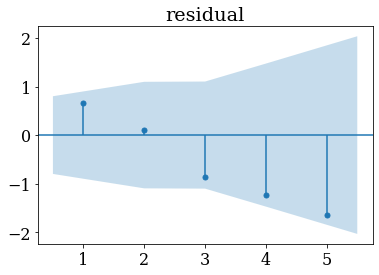

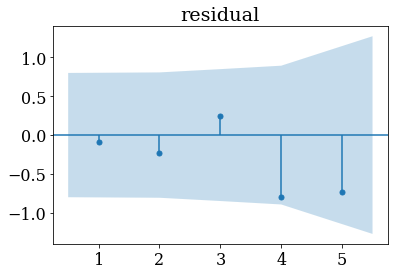

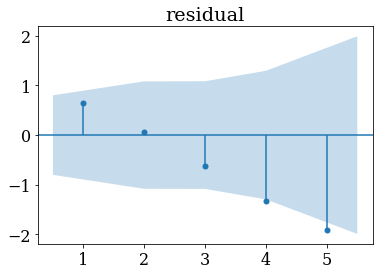

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

data_pm['total_residual'] = data_pm.register_total - (data_pm.t * 0.016 + 0.84)
data_pm['orthodox_residual'] = data_pm.register_orthodox - (data_pm.t * 0.1 + 0.0037)
data_pm['health_council_orthodox_residual'] = data_pm.health_council_orthodox - (data_pm.t * 0.0043 + 0.09)
plot_acf(data_pm.health_council_orthodox_residual[-13:], title='residual', adjusted=True, zero=False)
plot_acf(data_pm.orthodox_residual, title='residual', adjusted=True, zero=False)
plot_acf(data_pm.total_residual, title='residual', adjusted=True, zero=False)
print(data_pm.register_orthodox)